In [1]:
import subprocess
from multiprocessing import Pool,cpu_count
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline,interp2d,RectBivariateSpline,SmoothBivariateSpline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
import fileinput as fi
from peaks import *
import seaborn as sns
import pickle as pkl

%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

ERROR:root:File `'averaging.ipynb.py'` not found.
ERROR:root:File `'optimize_slope.ipynb.py'` not found.


## Loading results data

In [11]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/STEPS_AZ/16apr2020/"
result={}
#fname=fnames[10]
#sims=["archive/clamped/R150control","archive/clamped/R150ER2x","archive/clamped/R300ER2x","archive/clamped/R150ER3x","archive/clamped/R300ER3x"]
#["clamped/R150control","clamped/R150ER2x","clamped/R300ER2x","clamped/R150ER3x","clamped/R300ER3x"],\
      #"R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"]#"ryr_old","stores_blocked",
#sims=["12may2020/R150control","12may2020/R150ER2x","12may2020/R300ER2x","12may2020/R150ER3x","12may2020/R300ER3x"]
sims=["R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x","stores_blocked"]
isi_range=list(range(20,181,40))
fnames=["isi%d" %isi for isi in isi_range]
for sim_type in sims:
    result[sim_type]={}
    for fname in fnames:
        loc=res_loc+sim_type+'/'+fname+'/'+'result.dat'
        if os.path.isfile(loc):
            with open(loc,'r') as f:
                l=f.readlines()
                pr1,er1=float(l[1].split("\t")[0]),float(l[1].split("\t")[1])
                pr2,er2=float(l[2].split("\t")[0]),float(l[2].split("\t")[1])
                fac,fac_er=float(l[2].split("\t")[4]),float(l[2].split("\t")[5])
                result[sim_type][fname]=[pr1,pr2,fac,er1,er2,fac_er]
        else:
            result[sim_type][fname]=[np.nan]*5
            print("Path does not exist:",loc)
            
better_sim_names = {
    "ryr_old":"old model",
    "stores_blocked":"stores blocked",
    "archive/clamped/R150control":"Physiological Control", 
    "archive/clamped/R150ER2x":"Normal RyR, Double ER Calcium",
    "archive/clamped/R150ER3x":"Normal RyR, Triple ER Calcium",
    "archive/clamped/R300ER3x":"Double RyR, Triple ER Calcium",
    "archive/clamped/R300ER2x":"Double RyR, Double ER Calcium",
    "R150control":"Physiological Control", 
    "R150ER2x":"Normal RyR, Double ER Calcium",
    "R150ER3x":"Normal RyR, Triple ER Calcium",
    "R300ER3x":"Double RyR, Triple ER Calcium",
    "R300ER2x":"Double RyR, Double ER Calcium",
    "1apr2020/R150control":"Physiological Control", 
    "1apr2020/R150ER2x":"Normal RyR, Double ER Calcium",
    "1apr2020/R150ER3x":"Normal RyR, Triple ER Calcium",
    "1apr2020/R300ER3x":"Double RyR, Triple ER Calcium",
    "1apr2020/R300ER2x":"Double RyR, Double ER Calcium"
    
}

fnames

#print(VDCC_range)

['isi20', 'isi60', 'isi100', 'isi140', 'isi180']

In [12]:
result[sims[0]]["vdcc60"]

KeyError: 'vdcc60'

<Figure size 504x360 with 0 Axes>

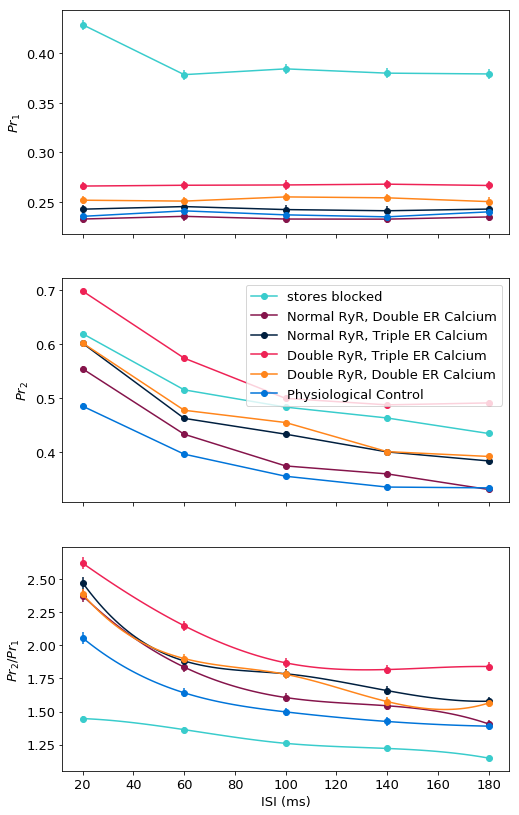

In [14]:
plt.figure(figsize=(7,5))
plt.rc('font',size=13)
#sims=["stores_blocked","R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"] #"ryr_old", 
#VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]


fig,ax=plt.subplots(3,1,figsize=(8,14),sharex=True)

for (sim_type,color) in reversed(list(zip(sims,cpalette))):
    Pr1=np.array([result[sim_type][fname][0] for fname in fnames])
    Pr1_err=np.array([result[sim_type][fname][3] for fname in fnames])
    ax[0].plot(isi_range,Pr1,marker='o',linestyle='-',color=color,label=better_sim_names[sim_type])
    ax[0].errorbar(isi_range,Pr1,yerr=Pr1_err,color=color,linestyle='')
    
    Pr2=np.array([result[sim_type][fname][1] for fname in fnames])
    Pr2_err=np.array([result[sim_type][fname][4] for fname in fnames])
    ax[1].plot(isi_range,Pr2,marker='o',linestyle='-',color=color,label=better_sim_names[sim_type])
    ax[1].errorbar(isi_range,Pr2,yerr=Pr2_err,color=color,linestyle='')
    
    fac=np.array([result[sim_type][fname][2] for fname in fnames])
    fac_er=np.array([result[sim_type][fname][5] for fname in fnames])
    ax[2].plot(isi_range,fac,marker='o',linestyle='',color=color,label=better_sim_names[sim_type])
    ax[2].errorbar(isi_range,fac,yerr=fac_er,color=color,linestyle='')
    
    #plt.errorbar(VDCC_range,ydata,yerr=yerr,color=color,linestyle='')
    #plt.scatter(VDCC_range,ydata)
    cs=CubicSpline(isi_range,fac)
    
    x_val=np.linspace(isi_range[0],isi_range[-1],101)
    y_val=cs(x_val)
    ax[2].plot(x_val,y_val,color=color)
   
    
ax[1].legend()
    
ax[0].set_ylabel("$Pr_{1}$")
ax[1].set_ylabel("$Pr_{2}$")
ax[2].set_ylabel("$Pr_{2}/Pr_{1}$")
ax[2].set_xlabel("ISI (ms)")
#plt.grid()
#plt.title("Vesicle Release Probability for the first pulse")
#plt.xlabel("VDCC number")
#plt.ylabel("$Pr_{1}$")
#plt.ylim(0,1)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/STEPS_AZ_isirange_murthy_dist.pdf",transparent=True)
#lt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/VDCCrangeP1.jpeg",dpi=300)

NameError: name 'VDCC_range' is not defined

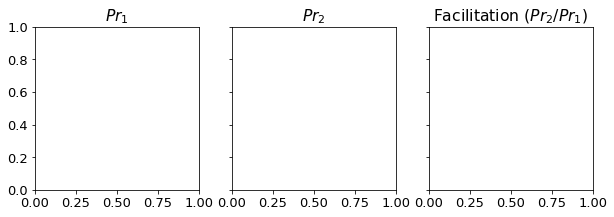

In [12]:
fig,ax=plt.subplots(1,3,figsize=(10,3),sharey=True)
#plt.rc('font',size=13)
#sims=["stores_blocked","R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"] #"ryr_old", 
#VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

pr1_data=[[result[sim_type][fname][0] for fname in fnames] for sim_type in sims]
pr2_data=[[result[sim_type][fname][1] for fname in fnames] for sim_type in sims]
ppf_data=[[result[sim_type][fname][2] for fname in fnames] for sim_type in sims]

y_title_margin=1
ax[0].set_title("$Pr_1$",      y = y_title_margin)
ax[1].set_title("$Pr_2$",      y = y_title_margin)
ax[2].set_title("Facilitation ($Pr_2/Pr_1$)", y = y_title_margin)          

sns.heatmap(pr1_data,vmin=0, vmax=1,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[0])
sns.heatmap(pr2_data,vmin=0, vmax=1,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[1])
sns.heatmap(ppf_data,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[2])

ax[0].set_xlabel("VDCC number")
ax[1].set_xlabel("VDCC number")
ax[2].set_xlabel("VDCC number")          

plt.tight_layout()
plt.subplots_adjust(left=0.27,bottom=0.25)

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/STEPS_AZ_ppr_heatmap_6apr2020.pdf",transparent=True)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/pr_heatmap.jpeg",dpi=300)

[7.557682384692962e-11, -3.990762546276006e-08, 6.727977039082453e-06, -0.00032452702956829976, -0.002707481501574378, 0.3696185816434417]


(0, 1.1)

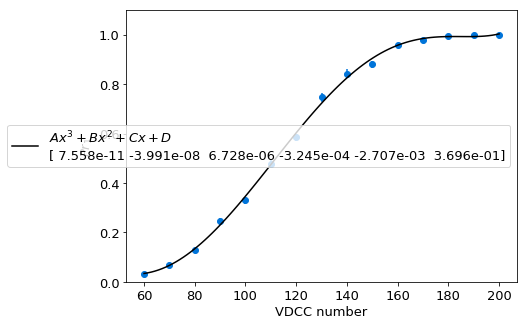

In [95]:
plt.figure(figsize=(7,5))
plt.rc('font',size=13)
#sims=["stores_blocked","R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"] #"ryr_old", 
#VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]


for (sim_type,color) in zip(sims,cpalette):
    ydata=[result[sim_type][fname][0] for fname in fnames]
    yerr=[result[sim_type][fname][3] for fname in fnames]
    plt.plot(VDCC_range,ydata,marker='o',linestyle='',color=color)#better_sim_names[sim_type]
    plt.errorbar(VDCC_range,ydata,yerr=yerr,color=color,linestyle='')
    #plt.scatter(VDCC_range,ydata)
    
    
    x_val=np.linspace(VDCC_range[0],VDCC_range[-1],100)
    
    #opt=curve_fit(func,VDCC_range,ydata)
    #plt.plot(x_val,func(x_val,*opt[0]),label='tanh')
    
    p=np.polyfit(VDCC_range,ydata,5)
    y_val=np.polyval(p,x_val)
    np.set_printoptions(precision=3)
    plt.plot(x_val,y_val,color=color[1],label='$Ax^3+Bx^2+Cx+D$\n'+str(p))
    print(list(p))
    
    cs=CubicSpline(VDCC_range,ydata)
    #cs_inv=CubicSpline(ydata,VDCC_range)
    x_val=np.linspace(VDCC_range[0],VDCC_range[-1],100)
    y_val=cs(x_val)#func(x_val,*opt[0])#np.polyval(p,x_val)
    #y_val=np.linspace(ydata[0],ydata[-1],100)
    #x_val=cs_inv(y_val)
    #plt.plot(x_val,y_val,color=color)

#x_val=np.linspace(VDCC_range[0],VDCC_range[-1],100)
#y_val=np.polyval([-1.205e-06, 4.109e-04, -3.469e-02, 8.770e-01],x_val)
#plt.plot(x_val,y_val,label='old_fit')    
    
plt.legend()
#plt.grid()
#plt.title("Vesicle Release Probability for the first pulse")
plt.xlabel("VDCC number")
plt.ylabel("$Pr_{1}$")
plt.ylim(0,1.1)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangeP1_polyfit_6apr2020.pdf",transparent=True)
#lt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/VDCCrangeP1.jpeg",dpi=300)

### [ 7.558e-11, -3.991e-08,  6.728e-06, -3.245e-04, -2.707e-03,  3.696e-01]

In [104]:
p=[7.557682384692962e-11, -3.990762546276006e-08, 6.727977039082453e-06, -0.00032452702956829976, \
   -0.002707481501574378, 0.3696185816434417]
der=np.polyder(p)
np.roots(der)



array([187.801, 182.158,  56.2  ,  -3.727])

### Calculating vdcc dist from murthy dist

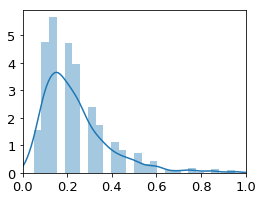

In [61]:
loc="/home/kabir/Project/tripartiteSynapse/murthy/Pr distribution-Murthy1997.dat"

murthy_dist=np.loadtxt(loc)
fig,ax=plt.subplots(1,1,figsize=(4,3))



y=[]
for i in range(20):
    y+=[murthy_dist[i,0]]*int(murthy_dist[i,1])
y=np.array(y)
ax.set_xlim((0,1))
ax=sns.distplot(y)

In [72]:
sol[np.where(np.isreal(sol)*(sol<170)*(sol>60))[0][0]].real

158.34210181814967

In [110]:
vdcc_dist=[]
for pr in murthy_dist[:,0]:
    to_solve=p.copy()
    to_solve[-1]=p[-1]-pr
    sol=np.roots(to_solve)
    vdcc_dist.append(int(np.round(sol[np.isreal(sol)].real[0])))

#vdcc_dist=np.array(np.round(cs_inv(murthy_dist[:,0])),dtype=int)
print(dict(list(zip(vdcc_dist,murthy_dist[:,1]/np.sum(murthy_dist[:,1])))),np.sum(murthy_dist[:,1]))
#print(vdcc_dist)

{66: 0.053833605220228384, 76: 0.16476345840130505, 82: 0.19575856443719414, 87: 0.1631321370309951, 92: 0.1370309951060359, 96: 0.08319738988580751, 100: 0.06035889070146819, 104: 0.03915171288743882, 108: 0.02936378466557912, 112: 0.024469820554649267, 116: 0.011419249592169658, 120: 0.01468189233278956, 124: 0.0032626427406199023, 128: 0.0032626427406199023, 132: 0.0065252854812398045, 137: 0.0016313213703099511, 143: 0.004893964110929853, 149: 0.0, 158: 0.0032626427406199023, 198: 0.0} 613.0


#### vdcc_dist = [66, 76, 82, 87, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 137, 143, 149, 158, 198]

Text(0, 0.5, '$Pr_{2}/Pr_{1}$')

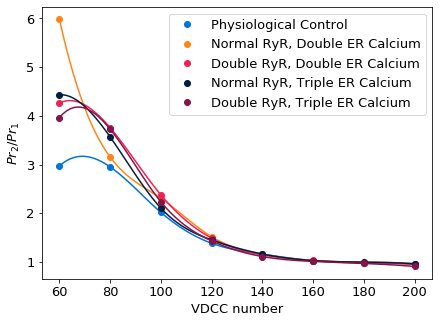

In [7]:
plt.figure(figsize=(7,5))
plt.rc('font',size=13)
#sims=["stores_blocked","R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"] #"ryr_old", 
#VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]


for (sim_type,color) in zip(sims,cpalette):
    ydata=[result[sim_type][fname][1]/result[sim_type][fname][0] for fname in fnames]
    #yerr=[result[sim_type][fname][1] for fname in fnames]
    plt.plot(VDCC_range,ydata,marker='o',linestyle='',color=color,label=better_sim_names[sim_type])
    #plt.errorbar(VDCC_range,ydata,yerr=yerr,color=color,linestyle='')
    #plt.scatter(VDCC_range,ydata)
    
    
    x_val=np.linspace(VDCC_range[0],VDCC_range[-1],101)
    #opt=curve_fit(func,VDCC_range,ydata)
    #plt.plot(x_val,func(x_val,*opt[0]),label='tanh')
    
    #p=np.polyfit(VDCC_range,ydata,3)
    #y_val=np.polyval(p,x_val)
    #np.set_printoptions(precision=3)
    #plt.plot(x_val,y_val,color=color[1],label='$Ax^3+Bx^2+Cx+D$\n'+str(p))
    #print(p)
    
    cs=CubicSpline(VDCC_range,ydata)
    #cs_inv=CubicSpline(ydata,VDCC_range)
    #x_val=np.linspace(VDCC_range[r],VDCC_range[-1],100)
    y_val=cs(x_val)#func(x_val,*opt[0])#np.polyval(p,x_val)
    #y_val=np.linspace(ydata[0],ydata[-1],100)
    #x_val=cs_inv(y_val)
    plt.plot(x_val,y_val,color=color)

#x_val=np.linspace(VDCC_range[0],VDCC_range[-1],100)
#y_val=np.polyval([-1.205e-06, 4.109e-04, -3.469e-02, 8.770e-01],x_val)
#plt.plot(x_val,y_val,label='old_fit')    
    
plt.legend()
#plt.grid()
#plt.title("Vesicle Release Probability for the first pulse")
plt.xlabel("VDCC number")
plt.ylabel("$Pr_{2}/Pr_{1}$")
#plt.ylim(0,2)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangeP1_190320.eps",transparent=True)
#lt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/VDCCrangeP1.jpeg",dpi=300)